In [21]:
from decoder_new import *
from encoder import *
from data_loader import *
import pickle
import random
import torch.optim as optim
from torch.autograd import Variable
import csv
import time
from tqdm import tqdm
import gc
import os
import torchvision.transforms as tf
import json
from matplotlib import pyplot as plt


In [22]:


def validate(val_loader, encoder, decoder, criterion, maxSeqLen, vocablen, use_gpu = True):

    #Evaluation Mode
    decoder.eval()
    encoder.eval()

    
    
    
    if use_gpu:
        device = torch.device("cuda:0")
        
        
    with torch.no_grad():
        
        count    = 0
        loss_avg = 0
        
        
        for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):

            # Move to device, if available
            if use_gpu:
                imgs = imgs.to(device)
                caps = caps.to(device)
            
            if (i % 1000) == 0:
                print('i: ',i)
                print('imgs: ',imgs)
                print('caps: ',caps)
                print('val_loader: ', val_loader)
                print('caplens: ',caplens)
            
            enc_out = encoder(imgs)
            actual_lengths = allcaps
            
            
            
            temperature = 1
            test_pred = decoder.generate_caption(enc_out, maxSeqLen, temperature)

            test_pred_sample = test_pred[0].cpu().numpy()          

            
            
            if i % 100 == 0:
                # Convert word_ids to words
                sampled_caption = []
                for word_id in test_pred_sample:
                    word = vocab.idx2word[word_id]
                    sampled_caption.append(word)
                    if word == '<end>':
                        break
                sentence = ' '.join(sampled_caption)
                print ('sentence: ',sentence)            
                        
            
            for b in range(batch_size):
                flag = False
                for wi in range(maxSeqLen):
                    if test_pred[b, wi] == 2:
                        flag = True
                    if flag:
                        test_pred[b, wi] = 0
            
            if i % 1000 == 0:
                print('VAL: test pred: ', test_pred)
                print('VAL: test pred shape: ', test_pred.size())
        
            outputs = decoder(caps, enc_out, actual_lengths)
            if i % 1000 == 0:
                print('VAL: outputs shape: ', outputs.size())
            new_outputs = torch.zeros(batch_size, maxSeqLen, vocablen)
            for dim in range(maxSeqLen):
                for b in range(batch_size):
                    new_outputs[b, dim, 0] = 1.0
            new_outputs[:, :(outputs.shape[1]), :] = outputs
            new_outputs = new_outputs.permute(0, 2, 1).to(device)
            #del inputs
            loss = criterion(new_outputs, Variable(caps.long()))
            loss_avg += loss
            count+=1
            
            del caps
            del outputs            
            
            print('VAL: loss: ', loss)
#            if i % 100 == 0:
#                break
        
        loss_avg = loss_avg/count
        print('VAL: loss_avg: ', loss_avg)
            
    return loss_avg

In [25]:
def trainEncoderDecoder(encoder, decoder, criterion, epochs,
                        train_loader,val_loader, test_loader,
                        name, batch_size, maxSeqLen, vocab):
    
    #Create non-existing logfiles
    logname = './logs/' + name + '.log'
    i = 0
    if os.path.exists(logname) == True:
        
        logname = './logs/' + name + str(i) + '.log'
        while os.path.exists(logname):
            i+=1
            logname = './logs/' + name + str(i) + '.log'

    print('Loading results to logfile: ' + logname)
    with open(logname, "w") as file:
        file.write("Log file DATA: Validation Loss and Accuracy\n") 
    
    logname_summary = './logs/' + name + '_summary' + str(i) + '.log'    
    print('Loading Summary to : ' + logname_summary) 
    
    parameters = list(encoder.parameters())
    parameters.extend(list(decoder.parameters()))
    optimizer = optim.Adam(parameters, lr=5e-3)
    use_gpu = torch.cuda.is_available()
    if use_gpu:
        device = torch.device("cuda:0")
#         encoder = torch.nn.DataParallel(encoder)
#         decoder = torch.nn.DataParallel(decoder)
        
        encoder.to(device)
        decoder.to(device)
        
        
    
    val_loss_set = []
    val_acc_set = []
    val_iou_set = []
    
    
    training_loss = []
    
    # Early Stop criteria
    minLoss = 1e6
    minLossIdx = 0
    earliestStopEpoch = 10
    earlyStopDelta = 5
    for epoch in range(epochs):
        ts = time.time()

        #import pdb; pdb.set_trace()                     
        for iter, (inputs, labels, lengths, actual_lengths) in tqdm(enumerate(train_loader)):

            optimizer.zero_grad()

            if use_gpu:
                inputs = inputs.to(device)# Move your inputs onto the gpu
                labels = labels.to(device) # Move your labels onto the gpu
            

            enc_out = encoder(inputs)

        
            temperature = 1
            
        
            outputs = decoder(labels, enc_out, actual_lengths) #calls forward

            new_outputs = torch.zeros(batch_size, maxSeqLen, vocab.idx)
            for dim in range(maxSeqLen):
                for b in range(batch_size):
                    new_outputs[b, dim, 0] = 1.0
            new_outputs[:, :(outputs.shape[1]), :] = outputs
            new_outputs = new_outputs.permute(0, 2, 1).to(device)
            #del inputs
            loss = criterion(new_outputs, Variable(labels.long()))
            del labels
            del outputs

            loss.backward()
            loss = loss#.item()
            optimizer.step()

            if iter % 200 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss))
                test_pred = decoder.generate_caption(enc_out, maxSeqLen, temperature).cpu()

                for b in range(batch_size):
                    caption = (" ").join([vocab.idx2word[x.item()] for x in test_pred[b]])
                    img = tf.ToPILImage()(inputs[b,:,:,:].cpu())
                    plt.imshow(img)
                    
                    plt.show()
                    print("Caption: " + caption)
                
            
#            if iter >=100:
#                break

        
        # calculate val loss each epoch
        val_loss  = validate(val_loader, encoder, decoder, criterion,maxSeqLen, vocab.idx, use_gpu)
        val_loss_set.append(val_loss)

        
#         print("epoch {}, time {}, train loss {}, val loss {}, val acc {}, val iou {}".format(epoch, time.time() - ts,
#                                                                                                loss, val_loss,
#                                                                                                val_acc,
#                                                                                                val_iou))        
        training_loss.append(loss)
        
        with open(logname, "a") as file:
            file.write("writing!\n")
            file.write("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
            file.write("\n training Loss:   " + str(loss.item()))
#             file.write("\n Validation Loss: " + str(val_loss_set[-1]))
#             file.write("\n Validation acc:  " + str(val_acc_set[-1]))
#             file.write("\n Validation iou:  " + str(val_iou_set[-1]) + "\n ")                                             
                                                                                                
                                                                                                
        
        # Early stopping
#         if val_loss < minLoss:
#             # Store new best
#             torch.save(model, name)
#             minLoss = val_loss#.item()
#             minLossIdx = epoch
            
        # If passed min threshold, and no new min has been reached for delta epochs
#         elif epoch > earliestStopEpoch and (epoch - minLossIdx) > earlyStopDelta:
#             print("Stopping early at {}".format(minLossIdx))
#             break
        

        
        
    with open(logname_summary, "a") as file:
            file.write("Summary!\n")
            file.write("Stopped early at {}".format(minLossIdx))
            file.write("\n training Loss:   " + str(training_loss))        
            file.write("\n Validation Loss: " + str(val_loss_set))
            file.write("\n Validation acc:  " + str(val_acc_set))
            file.write("\n Validation iou:  " + str(val_iou_set) + "\n ")
            
        
    #return val_loss_set, val_acc_set, val_iou_set



loading annotations into memory...
Done (t=0.84s)
creating index...
index created!
loading annotations into memory...
Done (t=0.72s)
creating index...
index created!
loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
Loading results to logfile: ./logs/LSTM25.log
Loading Summary to : ./logs/LSTM_summary25.log



0it [00:00, ?it/s]

temp shape:  torch.Size([4, 17, 50])
epoch0, iter0, loss: -0.6964589357376099
Caption: barrel house alcohol dips spraying herb childrens upscale baron preparing t-shirt bleak detailed lanes sleeve calm lighter dog combing squats elvis mixed stark solitary heeled take scatter clouds choice tubs wash pets mop antiques rapidly onto dvds deers balcony saw speeding hoodie stark solitary heeled take scatter clouds choice tubs wash pets mop antiques rapidly onto


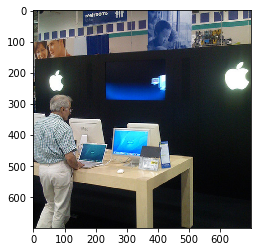

Caption: barrel house alcohol dips spraying herb childrens upscale baron preparing t-shirt bleak detailed lanes sleeve calm lighter dog combing squats elvis mixed stark solitary heeled take scatter clouds choice tubs wash pets mop antiques rapidly onto dvds deers balcony saw speeding hoodie stark solitary heeled take scatter clouds choice tubs wash pets mop antiques rapidly onto


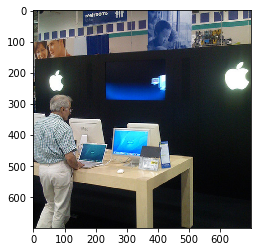

Caption: barrel house alcohol dips spraying herb childrens upscale baron preparing t-shirt bleak detailed lanes sleeve calm lighter dog combing squats elvis mixed stark solitary heeled take scatter clouds choice tubs wash pets mop antiques rapidly onto dvds deers balcony saw speeding hoodie stark solitary heeled take scatter clouds choice tubs wash pets mop antiques rapidly onto


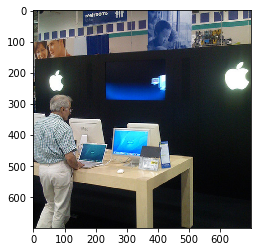

Caption: barrel house alcohol dips spraying herb childrens upscale baron preparing t-shirt bleak detailed lanes sleeve calm lighter dog combing squats elvis mixed stark solitary heeled take scatter clouds choice tubs wash pets mop antiques rapidly onto dvds deers balcony saw speeding hoodie stark solitary heeled take scatter clouds choice tubs wash pets mop antiques rapidly onto


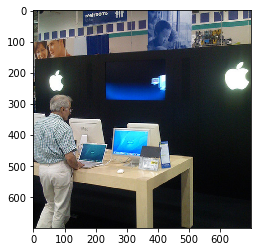


1it [00:01,  1.70s/it]
2it [00:01,  1.22s/it]
3it [00:01,  1.12it/s]

temp shape:  torch.Size([4, 16, 50])
temp shape:  torch.Size([4, 15, 50])



4it [00:02,  1.52it/s]
5it [00:02,  2.02it/s]

temp shape:  torch.Size([4, 14, 50])
temp shape:  torch.Size([4, 14, 50])



6it [00:02,  2.59it/s]

temp shape:  torch.Size([4, 15, 50])



7it [00:02,  2.96it/s]

temp shape:  torch.Size([4, 15, 50])
temp shape:  torch.Size([4, 16, 50])



8it [00:02,  3.41it/s]
9it [00:02,  3.68it/s]
10it [00:03,  4.27it/s]

temp shape:  torch.Size([4, 13, 50])
temp shape:  torch.Size([4, 17, 50])



11it [00:03,  4.42it/s]

temp shape:  torch.Size([4, 13, 50])
temp shape:  torch.Size([4, 16, 50])



12it [00:03,  4.68it/s]
13it [00:03,  4.88it/s]
14it [00:03,  5.32it/s]

temp shape:  torch.Size([4, 14, 50])
temp shape:  torch.Size([4, 13, 50])



15it [00:03,  5.54it/s]
16it [00:04,  5.83it/s]

temp shape:  torch.Size([4, 16, 50])
temp shape:  torch.Size([4, 15, 50])



17it [00:04,  5.74it/s]
18it [00:04,  5.77it/s]

temp shape:  torch.Size([4, 15, 50])
temp shape:  torch.Size([4, 16, 50])



19it [00:04,  6.07it/s]
20it [00:04,  5.94it/s]

temp shape:  torch.Size([4, 14, 50])
temp shape:  torch.Size([4, 15, 50])



21it [00:04,  5.72it/s]

temp shape:  torch.Size([4, 14, 50])
temp shape:  torch.Size([4, 16, 50])



22it [00:05,  5.61it/s]
23it [00:05,  5.43it/s]
24it [00:05,  5.67it/s]

temp shape:  torch.Size([4, 16, 50])
temp shape:  torch.Size([4, 45, 50])



25it [00:05,  5.61it/s]
26it [00:05,  5.90it/s]

temp shape:  torch.Size([4, 17, 50])
temp shape:  torch.Size([4, 13, 50])



27it [00:05,  6.38it/s]
28it [00:06,  6.34it/s]

temp shape:  torch.Size([4, 14, 50])
temp shape:  torch.Size([4, 17, 50])



29it [00:06,  6.19it/s]
30it [00:06,  6.19it/s]

temp shape:  torch.Size([4, 16, 50])
temp shape:  torch.Size([4, 17, 50])



31it [00:06,  6.02it/s]
32it [00:06,  6.53it/s]

temp shape:  torch.Size([4, 15, 50])
temp shape:  torch.Size([4, 14, 50])



33it [00:06,  6.07it/s]
34it [00:07,  6.65it/s]

temp shape:  torch.Size([4, 16, 50])
temp shape:  torch.Size([4, 15, 50])



35it [00:07,  6.48it/s]

temp shape:  torch.Size([4, 15, 50])
temp shape:  torch.Size([4, 15, 50])



36it [00:07,  6.09it/s]
37it [00:07,  6.11it/s]
38it [00:07,  6.12it/s]

temp shape:  torch.Size([4, 13, 50])
temp shape:  torch.Size([4, 13, 50])



39it [00:07,  6.02it/s]
40it [00:08,  6.14it/s]

temp shape:  torch.Size([4, 14, 50])
temp shape:  torch.Size([4, 17, 50])



41it [00:08,  6.14it/s]

temp shape:  torch.Size([4, 16, 50])
temp shape:  torch.Size([4, 14, 50])



42it [00:08,  5.85it/s]
43it [00:08,  5.83it/s]
44it [00:08,  6.06it/s]

temp shape:  torch.Size([4, 19, 50])
temp shape:  torch.Size([4, 13, 50])



45it [00:08,  6.23it/s]
46it [00:09,  6.54it/s]

temp shape:  torch.Size([4, 17, 50])
temp shape:  torch.Size([4, 16, 50])



47it [00:09,  6.38it/s]
48it [00:09,  6.35it/s]

temp shape:  torch.Size([4, 13, 50])
temp shape:  torch.Size([4, 14, 50])



49it [00:09,  6.33it/s]
50it [00:09,  6.83it/s]

temp shape:  torch.Size([4, 15, 50])
temp shape:  torch.Size([4, 16, 50])



51it [00:09,  6.05it/s]
52it [00:10,  6.09it/s]

temp shape:  torch.Size([4, 22, 50])
temp shape:  torch.Size([4, 14, 50])



53it [00:10,  5.40it/s]
54it [00:10,  6.02it/s]

temp shape:  torch.Size([4, 20, 50])
temp shape:  torch.Size([4, 19, 50])



55it [00:10,  5.87it/s]
56it [00:10,  6.00it/s]

temp shape:  torch.Size([4, 16, 50])
temp shape:  torch.Size([4, 24, 50])



57it [00:10,  5.87it/s]
58it [00:11,  5.97it/s]

temp shape:  torch.Size([4, 15, 50])
temp shape:  torch.Size([4, 21, 50])



59it [00:11,  6.40it/s]
60it [00:11,  6.97it/s]

temp shape:  torch.Size([4, 14, 50])
temp shape:  torch.Size([4, 16, 50])



61it [00:11,  6.62it/s]
62it [00:11,  6.40it/s]

temp shape:  torch.Size([4, 18, 50])
temp shape:  torch.Size([4, 15, 50])



63it [00:11,  6.18it/s]
64it [00:11,  6.08it/s]

temp shape:  torch.Size([4, 16, 50])
temp shape:  torch.Size([4, 17, 50])



65it [00:12,  5.72it/s]
66it [00:12,  6.38it/s]

temp shape:  torch.Size([4, 20, 50])
temp shape:  torch.Size([4, 17, 50])



67it [00:12,  6.00it/s]
68it [00:12,  6.10it/s]

temp shape:  torch.Size([4, 22, 50])
temp shape:  torch.Size([4, 13, 50])



69it [00:12,  6.04it/s]
70it [00:12,  6.20it/s]

temp shape:  torch.Size([4, 16, 50])
temp shape:  torch.Size([4, 14, 50])



71it [00:13,  5.96it/s]
72it [00:13,  6.15it/s]

temp shape:  torch.Size([4, 17, 50])
temp shape:  torch.Size([4, 16, 50])



73it [00:13,  6.02it/s]
74it [00:13,  6.42it/s]

temp shape:  torch.Size([4, 14, 50])
temp shape:  torch.Size([4, 15, 50])



75it [00:13,  6.63it/s]
76it [00:13,  6.87it/s]

temp shape:  torch.Size([4, 16, 50])
temp shape:  torch.Size([4, 17, 50])



77it [00:14,  6.77it/s]
78it [00:14,  7.25it/s]

temp shape:  torch.Size([4, 15, 50])
temp shape:  torch.Size([4, 14, 50])



79it [00:14,  7.24it/s]
80it [00:14,  7.52it/s]

temp shape:  torch.Size([4, 15, 50])
temp shape:  torch.Size([4, 23, 50])



81it [00:14,  7.51it/s]
82it [00:14,  7.66it/s]

temp shape:  torch.Size([4, 14, 50])
temp shape:  torch.Size([4, 15, 50])



83it [00:14,  7.53it/s]
84it [00:14,  7.85it/s]

temp shape:  torch.Size([4, 17, 50])
temp shape:  torch.Size([4, 14, 50])



85it [00:15,  7.37it/s]
86it [00:15,  7.70it/s]

temp shape:  torch.Size([4, 12, 50])
temp shape:  torch.Size([4, 17, 50])



87it [00:15,  7.34it/s]
88it [00:15,  7.41it/s]

temp shape:  torch.Size([4, 30, 50])
temp shape:  torch.Size([4, 15, 50])



89it [00:15,  6.61it/s]
90it [00:15,  6.87it/s]

temp shape:  torch.Size([4, 16, 50])
temp shape:  torch.Size([4, 23, 50])



91it [00:15,  6.56it/s]
92it [00:16,  6.41it/s]

temp shape:  torch.Size([4, 16, 50])
temp shape:  torch.Size([4, 16, 50])



93it [00:16,  6.15it/s]
94it [00:16,  6.27it/s]

temp shape:  torch.Size([4, 12, 50])
temp shape:  torch.Size([4, 17, 50])



95it [00:16,  5.74it/s]
96it [00:16,  6.04it/s]

temp shape:  torch.Size([4, 26, 50])
temp shape:  torch.Size([4, 22, 50])



97it [00:16,  6.02it/s]
98it [00:17,  6.59it/s]

temp shape:  torch.Size([4, 15, 50])
temp shape:  torch.Size([4, 18, 50])



99it [00:17,  6.14it/s]
100it [00:17,  6.51it/s]

temp shape:  torch.Size([4, 15, 50])
temp shape:  torch.Size([4, 16, 50])
temp shape:  torch.Size([4, 16, 50])
epoch0, iter100, loss: -0.7900661826133728
Caption: <start> a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


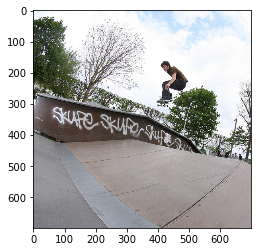

Caption: <start> a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


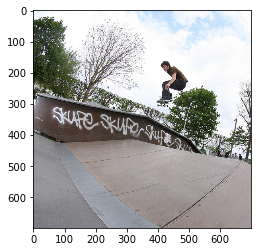

Caption: <start> a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


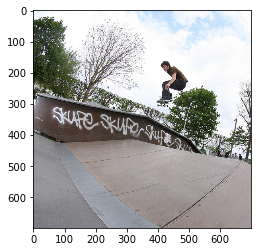

Caption: <start> a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


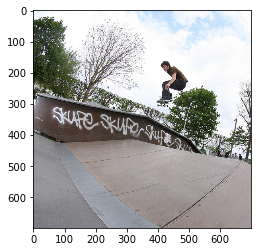


101it [00:18,  2.12it/s]
102it [00:18,  2.76it/s]
103it [00:18,  3.46it/s]

temp shape:  torch.Size([4, 17, 50])
temp shape:  torch.Size([4, 15, 50])



104it [00:18,  4.27it/s]
105it [00:19,  4.97it/s]

temp shape:  torch.Size([4, 16, 50])
temp shape:  torch.Size([4, 17, 50])



106it [00:19,  5.09it/s]

temp shape:  torch.Size([4, 13, 50])
temp shape:  torch.Size([4, 15, 50])



107it [00:19,  5.24it/s]
108it [00:19,  5.22it/s]
109it [00:19,  5.63it/s]

temp shape:  torch.Size([4, 22, 50])
temp shape:  torch.Size([4, 15, 50])



110it [00:19,  6.08it/s]
111it [00:20,  6.23it/s]

temp shape:  torch.Size([4, 17, 50])
temp shape:  torch.Size([4, 12, 50])



112it [00:20,  6.83it/s]

temp shape:  torch.Size([4, 16, 50])
temp shape:  torch.Size([4, 14, 50])



113it [00:20,  6.29it/s]
114it [00:20,  6.16it/s]
115it [00:20,  6.16it/s]

temp shape:  torch.Size([4, 17, 50])
temp shape:  torch.Size([4, 17, 50])



116it [00:20,  6.09it/s]

temp shape:  torch.Size([4, 14, 50])
temp shape:  torch.Size([4, 18, 50])



117it [00:21,  5.76it/s]
118it [00:21,  5.66it/s]
119it [00:21,  5.83it/s]

temp shape:  torch.Size([4, 15, 50])
temp shape:  torch.Size([4, 16, 50])



120it [00:21,  5.85it/s]

temp shape:  torch.Size([4, 19, 50])
temp shape:  torch.Size([4, 16, 50])



121it [00:21,  5.66it/s]
122it [00:21,  5.95it/s]

temp shape:  torch.Size([4, 16, 50])
temp shape:  torch.Size([4, 22, 50])



123it [00:22,  5.64it/s]
124it [00:22,  5.82it/s]
125it [00:22,  5.89it/s]

temp shape:  torch.Size([4, 13, 50])
temp shape:  torch.Size([4, 16, 50])



126it [00:22,  6.29it/s]

temp shape:  torch.Size([4, 15, 50])
temp shape:  torch.Size([4, 15, 50])



127it [00:22,  5.81it/s]
128it [00:22,  6.40it/s]

temp shape:  torch.Size([4, 13, 50])



129it [00:23,  5.62it/s]
130it [00:23,  6.17it/s]

temp shape:  torch.Size([4, 17, 50])
temp shape:  torch.Size([4, 14, 50])



131it [00:23,  5.65it/s]
132it [00:23,  5.81it/s]

temp shape:  torch.Size([4, 17, 50])
temp shape:  torch.Size([4, 17, 50])



133it [00:23,  5.70it/s]
134it [00:23,  5.81it/s]

temp shape:  torch.Size([4, 16, 50])
temp shape:  torch.Size([4, 22, 50])



135it [00:24,  5.73it/s]
136it [00:24,  6.23it/s]

temp shape:  torch.Size([4, 15, 50])
temp shape:  torch.Size([4, 17, 50])



137it [00:24,  6.00it/s]
138it [00:24,  6.53it/s]

temp shape:  torch.Size([4, 19, 50])
temp shape:  torch.Size([4, 16, 50])



139it [00:24,  6.26it/s]
140it [00:24,  6.79it/s]

temp shape:  torch.Size([4, 21, 50])
temp shape:  torch.Size([4, 16, 50])



141it [00:25,  6.34it/s]
142it [00:25,  6.43it/s]

temp shape:  torch.Size([4, 14, 50])
temp shape:  torch.Size([4, 16, 50])



143it [00:25,  6.09it/s]
144it [00:25,  6.41it/s]

temp shape:  torch.Size([4, 14, 50])
temp shape:  torch.Size([4, 16, 50])



145it [00:25,  6.27it/s]
146it [00:25,  6.07it/s]

temp shape:  torch.Size([4, 16, 50])
temp shape:  torch.Size([4, 16, 50])



147it [00:26,  5.74it/s]
148it [00:26,  5.86it/s]

temp shape:  torch.Size([4, 13, 50])
temp shape:  torch.Size([4, 13, 50])



149it [00:26,  5.79it/s]
150it [00:26,  6.00it/s]

temp shape:  torch.Size([4, 15, 50])
temp shape:  torch.Size([4, 15, 50])



151it [00:26,  5.40it/s]
152it [00:26,  5.69it/s]

temp shape:  torch.Size([4, 13, 50])
temp shape:  torch.Size([4, 16, 50])



153it [00:27,  5.89it/s]
154it [00:27,  6.21it/s]

temp shape:  torch.Size([4, 15, 50])
temp shape:  torch.Size([4, 16, 50])



155it [00:27,  6.06it/s]

temp shape:  torch.Size([4, 14, 50])
temp shape:  torch.Size([4, 16, 50])



156it [00:27,  5.86it/s]
157it [00:27,  5.65it/s]
158it [00:27,  5.89it/s]

temp shape:  torch.Size([4, 16, 50])
temp shape:  torch.Size([4, 16, 50])



159it [00:28,  5.75it/s]
160it [00:28,  6.35it/s]

temp shape:  torch.Size([4, 16, 50])
temp shape:  torch.Size([4, 14, 50])



161it [00:28,  6.13it/s]
162it [00:28,  6.36it/s]

temp shape:  torch.Size([4, 13, 50])
temp shape:  torch.Size([4, 15, 50])



163it [00:28,  6.02it/s]
164it [00:28,  6.43it/s]

temp shape:  torch.Size([4, 16, 50])
temp shape:  torch.Size([4, 18, 50])



165it [00:29,  5.97it/s]
166it [00:29,  5.89it/s]

temp shape:  torch.Size([4, 17, 50])
temp shape:  torch.Size([4, 19, 50])



167it [00:29,  5.60it/s]
168it [00:29,  5.96it/s]

temp shape:  torch.Size([4, 15, 50])
temp shape:  torch.Size([4, 14, 50])



169it [00:29,  5.51it/s]
170it [00:29,  5.71it/s]

temp shape:  torch.Size([4, 14, 50])
temp shape:  torch.Size([4, 16, 50])



171it [00:30,  5.52it/s]
172it [00:30,  6.06it/s]

temp shape:  torch.Size([4, 19, 50])
temp shape:  torch.Size([4, 12, 50])



173it [00:30,  5.65it/s]
174it [00:30,  5.99it/s]

temp shape:  torch.Size([4, 15, 50])
temp shape:  torch.Size([4, 13, 50])



175it [00:30,  5.73it/s]
176it [00:30,  5.82it/s]

temp shape:  torch.Size([4, 14, 50])
temp shape:  torch.Size([4, 14, 50])



177it [00:31,  5.77it/s]
178it [00:31,  5.89it/s]

temp shape:  torch.Size([4, 14, 50])
temp shape:  torch.Size([4, 15, 50])



179it [00:31,  5.93it/s]
180it [00:31,  6.25it/s]

temp shape:  torch.Size([4, 16, 50])
temp shape:  torch.Size([4, 15, 50])



181it [00:31,  6.26it/s]
182it [00:31,  6.08it/s]

temp shape:  torch.Size([4, 17, 50])
temp shape:  torch.Size([4, 22, 50])



183it [00:32,  6.22it/s]
184it [00:32,  6.06it/s]

temp shape:  torch.Size([4, 14, 50])
temp shape:  torch.Size([4, 17, 50])



185it [00:32,  5.88it/s]
186it [00:32,  6.23it/s]

temp shape:  torch.Size([4, 27, 50])
temp shape:  torch.Size([4, 16, 50])



187it [00:32,  6.20it/s]
188it [00:32,  6.16it/s]

temp shape:  torch.Size([4, 15, 50])
temp shape:  torch.Size([4, 17, 50])



189it [00:33,  5.68it/s]
190it [00:33,  6.05it/s]

temp shape:  torch.Size([4, 16, 50])
temp shape:  torch.Size([4, 18, 50])



191it [00:33,  5.60it/s]
192it [00:33,  5.65it/s]

temp shape:  torch.Size([4, 14, 50])
temp shape:  torch.Size([4, 15, 50])



193it [00:33,  5.44it/s]
194it [00:34,  5.83it/s]

temp shape:  torch.Size([4, 15, 50])
temp shape:  torch.Size([4, 16, 50])



195it [00:34,  5.70it/s]
196it [00:34,  6.45it/s]

temp shape:  torch.Size([4, 17, 50])
temp shape:  torch.Size([4, 15, 50])



197it [00:34,  6.39it/s]
198it [00:34,  6.65it/s]

temp shape:  torch.Size([4, 17, 50])
temp shape:  torch.Size([4, 21, 50])



199it [00:34,  6.56it/s]
200it [00:34,  6.69it/s]

temp shape:  torch.Size([4, 25, 50])
temp shape:  torch.Size([4, 15, 50])
temp shape:  torch.Size([4, 15, 50])
epoch0, iter200, loss: -0.8102697730064392
Caption: <start> a . <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>


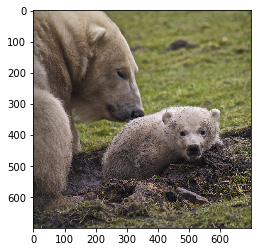

Caption: <start> a . <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>


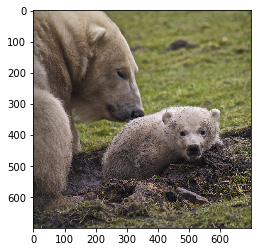

Caption: <start> a . <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>


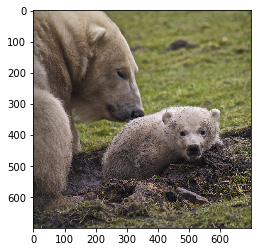

Caption: <start> a . <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>


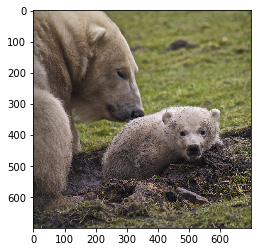


201it [00:36,  2.00it/s]
202it [00:36,  2.59it/s]
203it [00:36,  3.25it/s]

temp shape:  torch.Size([4, 15, 50])
temp shape:  torch.Size([4, 17, 50])



204it [00:36,  4.06it/s]
205it [00:36,  4.85it/s]

temp shape:  torch.Size([4, 13, 50])
temp shape:  torch.Size([4, 17, 50])



206it [00:36,  5.60it/s]

temp shape:  torch.Size([4, 12, 50])
temp shape:  torch.Size([4, 15, 50])



207it [00:36,  5.43it/s]
208it [00:37,  5.92it/s]

temp shape:  torch.Size([4, 13, 50])


KeyboardInterrupt: 

In [26]:
if __name__=='__main__':
    with open('TrainImageIds.csv', 'r') as f:
        reader = csv.reader(f)
        trainIds = list(reader)[0]
        
    with open('TestImageIds.csv', 'r') as f:
        reader = csv.reader(f)
        testIds = list(reader)[0]
    
    trainIds = [int(i) for i in trainIds]
    testIds = [int(i) for i in testIds]
    
    # Will shuffle the trainIds incase of ordering in csv
    random.shuffle(trainIds)
    splitIdx = int(len(trainIds)/5)
    
    # Selecting 1/5 of training set as validation
    valIds = trainIds[:splitIdx]
    trainIds = trainIds[splitIdx:]
    #print(trainIds)
    
    
    trainValRoot = "./data/images/train/"
    testRoot = "./data/images/test/"
    
    trainValJson = "./data/annotations/captions_train2014.json"
    testJson = "./data/annotations/captions_val2014.json"
    
    
    with open('./data/vocab.pkl', 'rb') as f:
        vocab = pickle.load(f)
    
    img_side_length = 700
    transform = tf.Compose([
        tf.Resize(img_side_length),
        #tf.RandomCrop(img_side_length),
        tf.CenterCrop(img_side_length),
        tf.ToTensor(),
    ])
    batch_size = 4
    shuffle = True
    num_workers = 1
    
    
    trainDl = get_loader(trainValRoot, trainValJson, trainIds, vocab, 
                         transform=transform, batch_size=batch_size, 
                         shuffle=False, num_workers=1)
    valDl = get_loader(trainValRoot, trainValJson, valIds, vocab, 
                         transform=transform, batch_size=batch_size, 
                         shuffle=shuffle, num_workers=1)
    testDl = get_loader(testRoot, testJson, testIds, vocab, 
                        transform=transform, batch_size=batch_size, 
                        shuffle=shuffle, num_workers=1)
    
    encoded_feature_dim = 56
    hidden_dim = 50
    
    encoder = Encoder(encoded_feature_dim)
    # Turn off all gradients in encoder
    for param in encoder.parameters():
        param.requires_grad = False
    # Turn on gradient of final hidden layer for fine tuning
    for param in encoder.fc.parameters():
        param.requires_grad = True
    decoder = Decoder(encoded_feature_dim, hidden_dim, vocab.idx)
    
    criterion = nn.NLLLoss()
    
    epochs = 100
    trainEncoderDecoder(encoder, decoder, criterion, epochs,
                        trainDl, valDl, testDl, "LSTM",
                        batch_size, encoded_feature_dim, vocab)
    
    
    
    
    
    
    

In [ ]:
%debug